# **CC6204 - Deep Learning**

# Tarea 2

## Equipo: 
- Daniel Carmona G.
- Consuelo Rojas N.

En esta tarea vas a experimentar con diferentes funciones de activación y su rol en el aprendizaje de redes neuronales. Lo primero que haremos es importar los paquetes importantes para nuestro notebook e inicializar el gpu. Asegúrate que tu notebook se ejecuta sobre un GPU. Si es así, al ejecutar la siguiente celda debería salirte el mensaje "cuda".

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


A continuación hay un conjunto de funciones que puedes usar para hacer tus experimentos. Los detalles de cada función están como comentario antes del código de la función.

In [3]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas():
  SEED = 1234

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred = model(x) #Feed the network with data
        
    loss = criterion(y_pred, y) #Compute the loss
       
    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
        
    loss.backward() #Compute gradients
        
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred= model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -tes_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, optimizer, train_loader, test_loader, name):
  
  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)

  #Fijar el entrenamiento en 20 épocas siempre
  EPOCHS = 20

  best_valid_acc = float('-inf')

  for epoch in range(EPOCHS):
    
    start_time = time.time()

    #Train + validation cycles  
    train_loss, train_acc = train_one_epoch(network, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(network, test_loader, criterion, device)
    
    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  
  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))

  test_loss , test_acc = evaluate(network, test_loader, criterion, device)
  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')

Para nuestros experimentos usaremos el dataset FashionMNIST, que consta de imágenes en escala de grises de 28x28 píxeles que representan prendas de ropa clasificadas en 10 clases. Inicializamos los hiperparámetros y cargamos los conjuntos de datos de entrenamiento y prueba. También se crean los dataloaders correspondientes.

In [4]:
# Hyper-parameters 
input_size = 784
num_classes = 10
batch_size_train = 1000
batch_size_test = 1000
momentum = 0.9
log_interval = 100
learning_rate=0.01

# MNIST dataset 
train_dataset = torchvision.datasets.FashionMNIST(root='data', 
                    train=True, 
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]),  
                    download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                          train=False, 
                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size_test, 
                                          shuffle=False)

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']


Inspeccionamos algunas muestras del conjunto de datos de prueba

Numero de batch: 0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


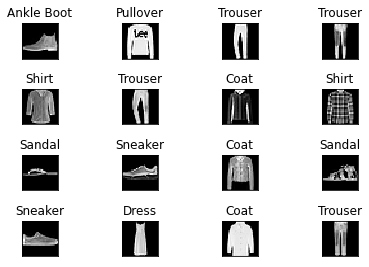

In [5]:
examples = enumerate(test_loader) #Crea un iterador sobre la lista de batches

batchId, (exampleData, exampleTargets) = next(examples) #Obtenemos el siguiente batch
print('Numero de batch: {}'.format(batchId))
print(exampleData.shape)
print(exampleTargets.shape)

import matplotlib.pyplot as plt

#Mostramos los primeros 6 elementos del batch con su etiqueta
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title(class_names[exampleTargets[i]])
  plt.xticks([])
  plt.yticks([])

# Parte 1 - Creación de red neuronal
Crea una arquitectura de red neuronal (MLP - multilayer perceptron) que reciba datos de 784 dimensiones (recuerda que las imágenes del experimento son de 28x28 = 784 píxeles) y tenga 10 neuronas de salida. Para esta primera red usa la función sigmoide como función de activación en todas las capas ocultas y la función softmax en la capa de salida (recuerda que si usas nn.CrossEntropyLoss, no necesitas aplicar ninguna función adicional a la última capa de la red).

In [6]:
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NetSigmoid(nn.Module):
  def __init__(self):
    super(NetSigmoid, self).__init__()
    # Define aquí las capas de tu red
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 , 64),
      nn.Sigmoid(),
      nn.Linear(64, 32),
      nn.Sigmoid(),
      nn.Linear(32, 10)
    )
    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    return self.layers(x)


Para ejecutar el entrenamiento de tu primer modelo, ejecuta la siguiente celda y debería reportarte el accuracy de prueba de este primer experimento. Cuánto obtienes de accuracy de test?

In [7]:
iniciar_semillas() # Se inicializan las semillas
network = NetSigmoid() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'sigmoid') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 1.206 | Train Acc: 59.78%
	 Val. Loss: 0.679 |  Val. Acc: 75.96%
Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.529 | Train Acc: 81.95%
	 Val. Loss: 0.486 |  Val. Acc: 82.86%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 0.420 | Train Acc: 85.13%
	 Val. Loss: 0.438 |  Val. Acc: 84.62%
Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 0.378 | Train Acc: 86.60%
	 Val. Loss: 0.418 |  Val. Acc: 84.90%
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 0.358 | Train Acc: 87.36%
	 Val. Loss: 0.406 |  Val. Acc: 85.13%
Epoch: 06 | Epoch Time: 0m 27s
	Train Loss: 0.341 | Train Acc: 87.80%
	 Val. Loss: 0.389 |  Val. Acc: 86.17%
Epoch: 07 | Epoch Time: 0m 31s
	Train Loss: 0.328 | Train Acc: 88.24%
	 Val. Loss: 0.382 |  Val. Acc: 86.07%
Epoch: 08 | Epoch Time: 0m 47s
	Train Loss: 0.309 | Train Acc: 88.91%
	 Val. Loss: 0.379 |  Val. Acc: 86.60%
Epoch: 09 | Epoch Time: 0m 59s
	Train Loss: 0.304 | Train Acc: 89.04%
	 Val. Loss: 0.375 |  Val. Acc: 86.87%
Epoch: 10 | Epoch T

La función sigmoide es una función continua y derivable, lo que ayuda a la propagación del error a las capas interiores de la red. Sin embargo, su rango de valores es [0,1], lo que hace que la salida de la función sigmoide sea muy pequeña, esto significa que tiene problemas de gradiente de fuga, es decir, que para valores muy alto o muy bajo, la derivada o error propagado es muy pequeño comparado con el real. Esto genera que la función sigmoide se bastante más lenta en comparación con otras funciones de activación, como la función ReLU.

Sobre la red, usualmente la función sigmoidea se utiliza para casos de clasificación binaria, más que multilabel. En este tipo de clasificaciones es mejor utilizar funciones como ReLu que tienen un rango de valores más amplio, lo que permite que la red aprenda más rápido y con mayor precisión y se utiliza cnormalmente con redes del tipo MLP (Multilayer Perceptron) o convolucionales.

Epoch: 20 | Epoch Time: 0m 30s   
	Train Loss: 0.246 | Train Acc: 91.08%   
	Val. Loss: 0.364 |  Val. Acc: 87.53%   
Test Loss: 0.364 | Mejor test acc: 87.53%

# Parte 2
En esta parte vas a comparar el accuracy de test de la primera red que creaste (con función de activación sigmoide) y los accuracys obtenidos usando otras funciones de activación. Para lograr esto debes hacer lo siguiente:



*   Implementa exactamente la misma arquitectura que tu primera red, pero ahora vas a usar las siguientes funciones de activación: Leaky Relu, Mish, Elu y Silu. Implementa una clase por cada función de activación, en donde la red neuronal use la misma función de activación en las capas ocultas. Asegúrate que la arquitectura es la misma y que lo único que cambia entre las distintas redes es la función de activación de las capas ocultas.
*   Entrena cada red usando la función "train_complete" usando el mismo optimizador siempre. 
*   Registra los mejores accuracys de test de cada red neuronal.
*   Discute los resultados obtenidos. Puedes tratar de responder a estas preguntas:
    * Qué función de activación dio el mejor accuracy de test?
    * Porqué crees que, ante las mismas condiciones, hay funciones de activación que funcionan mejor que otras?
    * Averigua cómo funcionan cada una de las funciones de activación usadas en la tarea. Es posible hacer algún razonamiento sobre el comportamiento de cada función y que eso permita explicar los resultados de tu tarea?

## Leaky ReLU

Leaky ReLu es una variante de ReLu de la forma $f(x) = max(\alpha x,x)$, con un $\alpha$ pequeño del orden $10^{-3}$.
Dentro de las ventajas que tiene esta función esta un pequeño valor de entrada y si el valor de entrada es negativo, el gradiente será $\alpha$. Por esto, la neurona no se muere y puede propagar errores de manera constante, lo que significa que seguirá aprendiendo. Además, la función Leaky ReLU es derivable en todo el rango de valores, lo que permite que la red aprenda más rápido y con mayor precisión.

Dentro de las desventajas que presenta es que el valor de $\alpha$ es un hiperparámetro que debe ser ajustado, además de que la función Leaky ReLU no es continua en $x=0$. Esto puede generar problemas de convergencia.

Epoch: 20 | Epoch Time: 0m 24s   
	Train Loss: 0.241 | Train Acc: 91.04%   
    Val. Loss: 0.395 |  Val. Acc: 86.68%   
Test Loss: 0.358 | Mejor test acc: 87.73%

In [11]:
class NetLeakyRelu(nn.Module):
  def __init__(self):
    super(NetLeakyRelu, self).__init__()
    # Define aquí las capas de tu red
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 , 64),
      nn.LeakyReLU(),
      nn.Linear(64, 32),
      nn.LeakyReLU(),
      nn.Linear(32, 10)
    )
    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    return self.layers(x)

In [12]:
iniciar_semillas() # Se inicializan las semillas
network_LR = NetLeakyRelu() # Creas la red
optimizer_LR = optim.Adam(network_LR.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network_LR, optimizer_LR, train_loader, test_loader, 'leakyrelu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 29s
	Train Loss: 0.708 | Train Acc: 73.88%
	 Val. Loss: 0.485 |  Val. Acc: 82.97%
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.418 | Train Acc: 84.93%
	 Val. Loss: 0.441 |  Val. Acc: 83.58%
Epoch: 03 | Epoch Time: 0m 26s
	Train Loss: 0.382 | Train Acc: 86.03%
	 Val. Loss: 0.397 |  Val. Acc: 85.66%
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.347 | Train Acc: 87.35%
	 Val. Loss: 0.396 |  Val. Acc: 85.62%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 0.326 | Train Acc: 88.16%
	 Val. Loss: 0.374 |  Val. Acc: 86.75%
Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 0.322 | Train Acc: 88.17%
	 Val. Loss: 0.378 |  Val. Acc: 86.30%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 0.305 | Train Acc: 88.70%
	 Val. Loss: 0.380 |  Val. Acc: 86.65%
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.306 | Train Acc: 88.69%
	 Val. Loss: 0.377 |  Val. Acc: 86.69%
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.287 | Train Acc: 89.44%
	 Val. Loss: 0.364 |  Val. Acc: 86.77%
Epoch: 10 | Epoch T

## Mish

Mish es una función de activación que combina la función sigmoide y la función tanh. La función Mish es derivable en todo el rango de valores, lo que permite que la red aprenda más rápido y con mayor precisión. Además, la función Mish es continua en $x=0$, esto hace que no tenga problemas de convergencia, a diferencia de la función Leaky ReLU.

La función de activación se describe con la forma: $f(x) = x tanh(\ln(1+e^x))$. Donde $\ln(1+e^x)$ corresponde a la función de activación softplus.

Esta función es acotada de manera inferior, pero no superior, lo que significa que la función no tiene problemas de gradiente de fuga, pero tampoco tiene problemas de saturación. Además es clase $C^{\infty}$, por lo que es derivable de manera infinita. Sin embargo, sus costos computacionales son altos y debe usarse en capas ocultas.


Epoch: 20 | Epoch Time: 0m 22s   
	Train Loss: 0.233 | Train Acc: 91.33%   
	 Val. Loss: 0.392 |  Val. Acc: 87.09%   
Test Loss: 0.359 | Mejor test acc: 88.13%

In [13]:
class NetMish(nn.Module):
  def __init__(self):
    super(NetMish, self).__init__()
    # Define aquí las capas de tu red
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 , 64),
      nn.Mish(),
      nn.Linear(64, 32),
      nn.Mish(),
      nn.Linear(32, 10)
    )
    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    return self.layers(x)

In [14]:
iniciar_semillas() # Se inicializan las semillas
network_m = NetMish() # Creas la red
optimizer_m = optim.Adam(network_m.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network_m, optimizer_m, train_loader, test_loader, 'mish') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 30s
	Train Loss: 0.672 | Train Acc: 75.48%
	 Val. Loss: 0.468 |  Val. Acc: 83.00%
Epoch: 02 | Epoch Time: 0m 40s
	Train Loss: 0.415 | Train Acc: 84.91%
	 Val. Loss: 0.436 |  Val. Acc: 83.90%
Epoch: 03 | Epoch Time: 0m 42s
	Train Loss: 0.369 | Train Acc: 86.45%
	 Val. Loss: 0.394 |  Val. Acc: 85.81%
Epoch: 04 | Epoch Time: 0m 38s
	Train Loss: 0.334 | Train Acc: 87.77%
	 Val. Loss: 0.402 |  Val. Acc: 85.35%
Epoch: 05 | Epoch Time: 0m 39s
	Train Loss: 0.324 | Train Acc: 88.01%
	 Val. Loss: 0.385 |  Val. Acc: 86.53%
Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 0.307 | Train Acc: 88.69%
	 Val. Loss: 0.374 |  Val. Acc: 86.69%
Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 0.302 | Train Acc: 88.80%
	 Val. Loss: 0.383 |  Val. Acc: 86.52%
Epoch: 08 | Epoch Time: 0m 36s
	Train Loss: 0.285 | Train Acc: 89.35%
	 Val. Loss: 0.362 |  Val. Acc: 87.26%
Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.271 | Train Acc: 89.93%
	 Val. Loss: 0.358 |  Val. Acc: 87.34%
Epoch: 10 | Epoch T

## ELU


Otra variante de ReLu de la forma $f(x) = x$ si $x>0$ y $f(x) = \alpha(e^x-1)$ si $x\leq 0$, con un $\alpha$ pequeño del orden $10^{-3}$.
Una de las grandes diferencias con ReLu es que esta función puede obtener valores negativos, lo que permite que los valores se acerquen más a cero, tal como pasa con un "batch normalization", pero con un menor costo computacional.

Además, este tipo de función es robusto al ruido dado que ELU satura a negativos con valores pequeños de input, por lo que disminuye la variación y la información que se propaga hacia adelante.

Sin embargo, al estar conformada por una función exponencial, es computacionalmente costosa y también solo se ocupa en capas ocultas.


Epoch: 20 | Epoch Time: 0m 18s   
	Train Loss: 0.216 | Train Acc: 91.87%   
	 Val. Loss: 0.367 |  Val. Acc: 87.80%   
Test Loss: 0.356 | Mejor test acc: 88.32%

In [15]:
class NetElu(nn.Module):
  def __init__(self):
    super(NetElu, self).__init__()
    # Define aquí las capas de tu red
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 , 64),
      nn.ELU(),
      nn.Linear(64, 32),
      nn.ELU(),
      nn.Linear(32, 10)
    )
    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    return self.layers(x)

In [16]:
iniciar_semillas() # Se inicializan las semillas
network_e = NetElu() # Creas la red
optimizer_e = optim.Adam(network_e.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network_e, optimizer_e, train_loader, test_loader, 'elu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.670 | Train Acc: 75.63%
	 Val. Loss: 0.471 |  Val. Acc: 82.98%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 0.410 | Train Acc: 85.11%
	 Val. Loss: 0.431 |  Val. Acc: 84.20%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 0.366 | Train Acc: 86.55%
	 Val. Loss: 0.386 |  Val. Acc: 86.15%
Epoch: 04 | Epoch Time: 0m 20s
	Train Loss: 0.335 | Train Acc: 87.76%
	 Val. Loss: 0.396 |  Val. Acc: 85.62%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 0.321 | Train Acc: 88.27%
	 Val. Loss: 0.367 |  Val. Acc: 86.74%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.312 | Train Acc: 88.48%
	 Val. Loss: 0.361 |  Val. Acc: 86.93%
Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 0.294 | Train Acc: 89.15%
	 Val. Loss: 0.369 |  Val. Acc: 86.76%
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.282 | Train Acc: 89.58%
	 Val. Loss: 0.363 |  Val. Acc: 87.02%
Epoch: 09 | Epoch Time: 0m 38s
	Train Loss: 0.268 | Train Acc: 90.15%
	 Val. Loss: 0.370 |  Val. Acc: 87.07%
Epoch: 10 | Epoch T

## SiLU

Variación de la función sigmoidea de la forma:
$$f(x) = \frac{x}{1+e^{-x}}$$
Tiene los mismos problemas de continuidad que la función sigmoidea y además solo se usa en capas ocultas de redes profundas. Usualmente, se ocupa en sistemas de entrenamiento por refuerzo.

Sus resultados no deberían variar mucho con respecto a la función sigmoidea, pero se espera que sea más rápida computacionalmente.

In [17]:
class NetSilu(nn.Module):
  def __init__(self):
    super(NetSilu, self).__init__()
    # Define aquí las capas de tu red
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 , 64),
      nn.SiLU(),
      nn.Linear(64, 32),
      nn.SiLU(),
      nn.Linear(32, 10)
    )
    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    return self.layers(x)

In [18]:
iniciar_semillas() # Se inicializan las semillas
network_s = NetSilu() # Creas la red
optimizer_s = optim.Adam(network_s.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network_s, optimizer_s, train_loader, test_loader, 'silu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 0.662 | Train Acc: 75.80%
	 Val. Loss: 0.474 |  Val. Acc: 83.27%
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.410 | Train Acc: 84.95%
	 Val. Loss: 0.430 |  Val. Acc: 84.63%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.373 | Train Acc: 86.23%
	 Val. Loss: 0.391 |  Val. Acc: 85.79%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.333 | Train Acc: 87.79%
	 Val. Loss: 0.388 |  Val. Acc: 85.93%
Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.328 | Train Acc: 87.84%
	 Val. Loss: 0.377 |  Val. Acc: 86.19%
Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 0.317 | Train Acc: 88.27%
	 Val. Loss: 0.367 |  Val. Acc: 86.86%
Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.297 | Train Acc: 89.04%
	 Val. Loss: 0.373 |  Val. Acc: 86.75%
Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 0.284 | Train Acc: 89.37%
	 Val. Loss: 0.366 |  Val. Acc: 86.86%
Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.267 | Train Acc: 90.05%
	 Val. Loss: 0.361 |  Val. Acc: 87.38%
Epoch: 10 | Epoch T

Epoch: 20 | Epoch Time: 0m 32s
	Train Loss: 0.219 | Train Acc: 91.90%   
	 Val. Loss: 0.367 |  Val. Acc: 87.80%   
Test Loss: 0.361 | Mejor test acc: 87.84%